In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import sys
sys.path.append("../")
from estimators.N_estimators import sample_mean_and_cov, GFA_EM
from estimators.estimators_utils import GFA_params, PCFA_via_corr
from estimators.T_estimators import TFA_ECME
from estimators.Tyler_FA_CCP import Tyler_FA_via_CCP
from experiments.utils import generate_samples, scatter_to_corr, errors_corr
np.random.seed(0)

In [2]:
# download data
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK-B', 'NVDA', 'META', 'TSLA', 
    'UNH', 'XOM', 'JNJ', 'V', 'PG', 'JPM', 'MA', 'LLY', 'HD', 'MRK',
    'AVGO', 'PEP', 'KO', 'CVX', 'ABBV', 'PFE', 'COST', 'MCD', 'TMO',
    'WMT', 'NFLX', 'DIS', 'ABT', 'CSCO', 'VZ', 'ACN', 'DHR', 'ADBE', 
    'NEE', 'NKE', 'CRM', 'TXN', 'QCOM', 'INTC', 'LIN', 'AMGN', 'MDT',
    'PM', 'HON', 'MS', 'AMT', 'BA'
]
data = yf.download(tickers, start="2023-01-01", end="2024-01-01")['Adj Close']
data.dropna(inplace=True)
returns = data.pct_change().dropna().values.T
S_true = sample_mean_and_cov(returns)[1]

# compute "true" covariance matrix
rank = 5
F_true, d_true = PCFA_via_corr(S_true, rank)
cov_true = F_true @ F_true.T + np.diag(d_true)
cov_true = F_true @ F_true.T + np.diag(d_true)
corr_true = scatter_to_corr([cov_true])[0]
n = cov_true.shape[0]

[*********************100%***********************]  50 of 50 completed


In [3]:
# settings for experiment
num_runs, all_m = 10, [100, 150, 200, 250, 300]
errors_Gaussian_data_no_outliers_GFA = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_no_outliers_TyFA = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_no_outliers_TFA = np.zeros((num_runs, len(all_m)))

errors_Gaussian_data_outliers_GFA = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_outliers_TyFA = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_outliers_TFA = np.zeros((num_runs, len(all_m)))

errors_multiT_data_no_outliers_GFA = np.zeros((num_runs, len(all_m)))
errors_multiT_data_no_outliers_TyFA = np.zeros((num_runs, len(all_m)))
errors_multiT_data_no_outliers_TFA = np.zeros((num_runs, len(all_m)))

degrees_of_freedom = 3
noise_factor = 3
percentage_outliers = 0.02

In [4]:
for distribution in ['N', 'T']:
    for outliers in [False, True]:
        if distribution == "T" and outliers == True:
            continue
        for i in range(len(all_m)):
            m = all_m[i]
            for run in range(num_runs):
                print("m / run: ", m, run)
                if distribution == "N":
                    X = generate_samples(m, "N", {'mu': np.zeros((n, )), 'cov': cov_true})
                else:
                    X = generate_samples(m, "T", {'mu': np.zeros((n, )), 'cov': cov_true, 'v': degrees_of_freedom})

                if outliers:
                    num_of_outliers = int(percentage_outliers*m)
                    mu_outliers = np.ones((n,))
                    mu_outliers[int(n/2):] *= -1
                    mu_outliers /= LA.norm(mu_outliers)
                    mu_outliers *= noise_factor*np.sqrt(np.trace(cov_true))
                
                    outliers_X = generate_samples(num_of_outliers, 'N', {'mu': mu_outliers, 'cov': cov_true})
                    if num_of_outliers == 1:
                        outliers_X = outliers_X.reshape(-1, 1)
                    X = np.hstack([X, outliers_X])

                X = X - np.mean(X, axis=1, keepdims=True)

                
                # compute factor model via Gaussian EM
                params_GFA_EM = GFA_params(max_iter=200, eps_rel_obj=1e-5, eps_rel_KKT=1e-6,
                                        term_interval=10, track_obj=True, track_KKT=True,
                                        eta=0, verbose=False)
                S_EM = sample_mean_and_cov(X)[1]
                F_G_EM, d_G_EM, stats_G_EM = GFA_EM(S_EM, rank, params=params_GFA_EM)

                 # compute factor model via T
                F_T, d_T = TFA_ECME(X, rank)

                # compute factor model via Tyler CCP 
                G_Ty, e_Ty, stats = Tyler_FA_via_CCP(X, rank, 20)
        
                           
                scatter_G_EM = F_G_EM @ F_G_EM.T + np.diag(d_G_EM)
                scatter_Tyler_EM = LA.inv(np.diag(e_Ty) - G_Ty @ G_Ty.T)
                scatter_T_ECME = F_T @ F_T.T + np.diag(d_T)
               

                errors = errors_corr([scatter_G_EM, scatter_Tyler_EM, 
                                      scatter_T_ECME], true_corr=corr_true)


                if distribution == "N" and not outliers:
                    errors_Gaussian_data_no_outliers_GFA[run, i] = errors[0]
                    errors_Gaussian_data_no_outliers_TyFA[run, i] = errors[1]
                    errors_Gaussian_data_no_outliers_TFA[run, i] = errors[2]
                elif distribution == "N" and outliers:
                    errors_Gaussian_data_outliers_GFA[run, i] = errors[0]
                    errors_Gaussian_data_outliers_TyFA[run, i] = errors[1]
                    errors_Gaussian_data_outliers_TFA[run, i] = errors[2]
                else:
                    errors_multiT_data_no_outliers_GFA[run, i] = errors[0]
                    errors_multiT_data_no_outliers_TyFA[run, i] = errors[1]
                    errors_multiT_data_no_outliers_TFA[run, i] = errors[2]
                   
                print("Tyler / Gaussian / T: ", errors[1], errors[0], errors[2])

m / run:  100 0
obj / norm(grad_e) / norm(grad_G):  -256.9021935744241 0.0001608625140349789 0.09530627239704777
obj / norm(grad_e) / norm(grad_G):  -257.1166277213077 3.763666038312821e-05 0.006545922881128303
obj / norm(grad_e) / norm(grad_G):  -257.150110164224 2.6552337175574705e-05 0.005370343310459986
obj / norm(grad_e) / norm(grad_G):  -257.16700932903314 1.1556939988009875e-05 0.0024863546662856105
obj / norm(grad_e) / norm(grad_G):  -257.17314823820334 6.765942767300689e-06 0.0014030879361833352
obj / norm(grad_e) / norm(grad_G):  -257.17694622199014 3.166665331142543e-06 0.0012573933686955334
obj / norm(grad_e) / norm(grad_G):  -257.1778537842468 1.8452696683494253e-06 0.0005068831743740101
obj / norm(grad_e) / norm(grad_G):  -257.178002395262 1.24658891912348e-06 0.00033944880171655345
obj / norm(grad_e) / norm(grad_G):  -257.17813450141887 8.827721846819235e-07 0.0002915017629791164
obj / norm(grad_e) / norm(grad_G):  -257.1781582205034 8.043526548754356e-07 0.0001912114083

In [19]:
MSE_errors_Gaussian_data_no_outliers_GFA = np.mean(errors_Gaussian_data_no_outliers_GFA, axis=0)
MSE_errors_Gaussian_data_no_outliers_TyFA = np.mean(errors_Gaussian_data_no_outliers_TyFA, axis=0)
MSE_errors_Gaussian_data_no_outliers_TFA = np.mean(errors_Gaussian_data_no_outliers_TFA, axis=0)
STD_errors_Gaussian_data_no_outliers_GFA = np.std(errors_Gaussian_data_no_outliers_GFA, axis=0)
STD_errors_Gaussian_data_no_outliers_TyFA = np.std(errors_Gaussian_data_no_outliers_TyFA, axis=0)
STD_errors_Gaussian_data_no_outliers_TFA = np.std(errors_Gaussian_data_no_outliers_TFA, axis=0)

print("Ratio TFA, GFA: ", MSE_errors_Gaussian_data_no_outliers_TFA / MSE_errors_Gaussian_data_no_outliers_GFA )
print("Ratio TyFA, GFA: ", MSE_errors_Gaussian_data_no_outliers_TyFA / MSE_errors_Gaussian_data_no_outliers_GFA )

MSE_errors_Gaussian_data_outliers_GFA = np.mean(errors_Gaussian_data_outliers_GFA, axis=0)
MSE_errors_Gaussian_data_outliers_TyFA = np.mean(errors_Gaussian_data_outliers_TyFA, axis=0)
MSE_errors_Gaussian_data_outliers_TFA = np.mean(errors_Gaussian_data_outliers_TFA, axis=0)
STD_errors_Gaussian_data_outliers_GFA = np.std(errors_Gaussian_data_outliers_GFA, axis=0)
STD_errors_Gaussian_data_outliers_TyFA = np.std(errors_Gaussian_data_outliers_TyFA, axis=0)
STD_errors_Gaussian_data_outliers_TFA = np.std(errors_Gaussian_data_outliers_TFA, axis=0)

MSE_errors_multiT_data_no_outliers_GFA = np.mean(errors_multiT_data_no_outliers_GFA, axis=0)
MSE_errors_multiT_data_no_outliers_TyFA = np.mean(errors_multiT_data_no_outliers_TyFA, axis=0)
MSE_errors_multiT_data_no_outliers_TFA = np.mean(errors_multiT_data_no_outliers_TFA, axis=0)
STD_errors_multiT_data_no_outliers_GFA = np.std(errors_multiT_data_no_outliers_GFA, axis=0)
STD_errors_multiT_data_no_outliers_TyFA = np.std(errors_multiT_data_no_outliers_TyFA, axis=0)
STD_errors_multiT_data_no_outliers_TFA = np.std(errors_multiT_data_no_outliers_TFA, axis=0)


Ratio TFA, GFA:  [1.02322317 1.09898589 1.12921287 1.13695011 1.1991056 ]
Ratio TyFA, GFA:  [1.04561731 1.03212746 1.02607619 1.01553488 1.01066514]


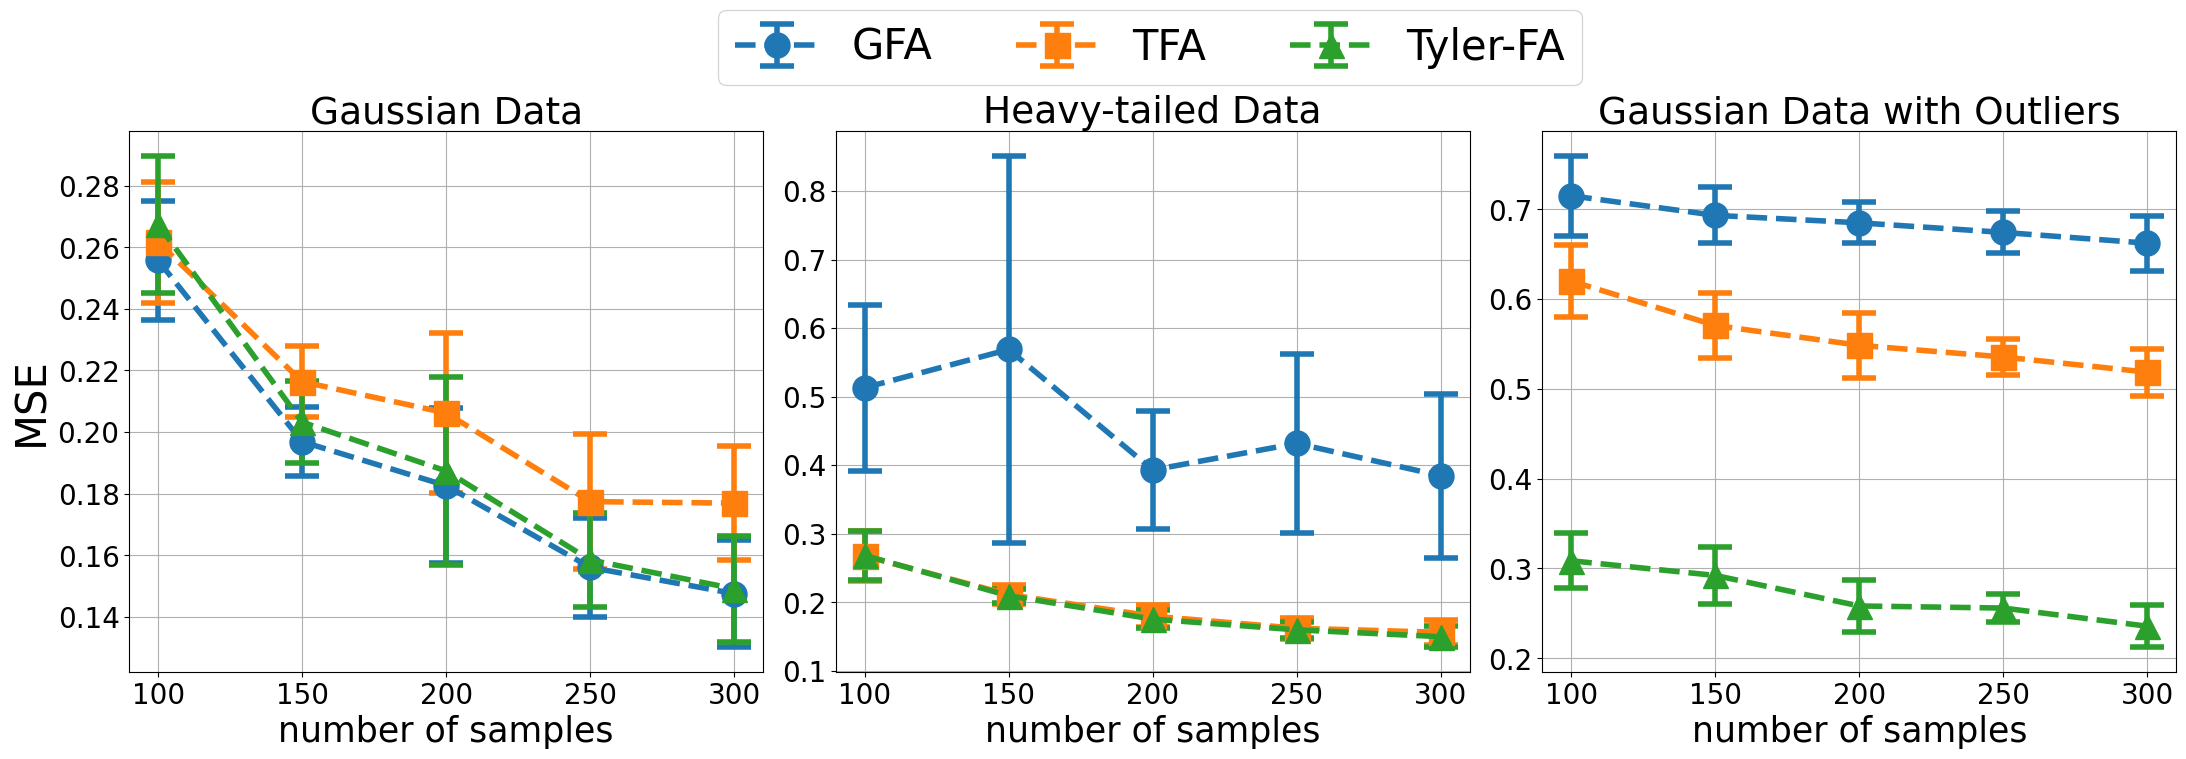

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(22, 7.6), sharey=False)
MARKERSIZE, CAPSIZE, CAPTHICK, ELINEWIDTH, LINEWIDTH = 18, 12, 4, 4, 4
FONTSIZE_Y, FONTSIZE_X = 30, 25

axs[0].errorbar(all_m, MSE_errors_Gaussian_data_no_outliers_GFA, 
                yerr=STD_errors_Gaussian_data_no_outliers_GFA, 
                marker='o', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH, label="GFA")

axs[0].errorbar(all_m, MSE_errors_Gaussian_data_no_outliers_TFA, 
                yerr=STD_errors_Gaussian_data_no_outliers_TFA, 
                marker='s', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH, label="TFA")


axs[0].errorbar(all_m, MSE_errors_Gaussian_data_no_outliers_TyFA, 
                yerr=STD_errors_Gaussian_data_no_outliers_TyFA, 
                marker='^', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH, label="Tyler-FA")


axs[1].errorbar(all_m, MSE_errors_multiT_data_no_outliers_GFA, 
                yerr=STD_errors_multiT_data_no_outliers_GFA, 
                marker='o', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)

axs[1].errorbar(all_m, MSE_errors_multiT_data_no_outliers_TFA, 
                yerr=STD_errors_multiT_data_no_outliers_TFA, 
                marker='s', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)


axs[1].errorbar(all_m, MSE_errors_multiT_data_no_outliers_TyFA, 
                yerr=STD_errors_multiT_data_no_outliers_TyFA, 
                marker='^', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)


axs[2].errorbar(all_m, MSE_errors_Gaussian_data_outliers_GFA, 
                yerr=STD_errors_Gaussian_data_outliers_GFA, 
                marker='o', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)

axs[2].errorbar(all_m, MSE_errors_Gaussian_data_outliers_TFA, 
                yerr=STD_errors_Gaussian_data_outliers_TFA, 
                marker='s', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)


axs[2].errorbar(all_m, MSE_errors_Gaussian_data_outliers_TyFA, 
                yerr=STD_errors_Gaussian_data_outliers_TyFA, 
                marker='^', linestyle='--',  linewidth=LINEWIDTH,
                markersize=MARKERSIZE, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=20)

axs[0].set_ylabel('MSE', fontsize=FONTSIZE_Y)
axs[0].set_xlabel('number of samples', fontsize=FONTSIZE_X)
axs[1].set_xlabel('number of samples', fontsize=FONTSIZE_X)
axs[2].set_xlabel('number of samples', fontsize=FONTSIZE_X)
axs[0].set_title('Gaussian Data', fontsize=27)
axs[1].set_title('Heavy-tailed Data', fontsize=27)
axs[2].set_title('Gaussian Data with Outliers', fontsize=27)
plt.tight_layout(rect=[0, 0, 1, 0.90])
fig.legend(fontsize=30, loc='upper center', bbox_to_anchor=(0.525, 1.02), ncol=3)

plt.savefig("synthetic_data_MSE.pdf")

